# Fine-tune LLM to follow instructions


## Load open weights

In [172]:
import wget

from gpt2_v2 import GPT2Model, GPT_CONFIG_124M, complete_text, generate_text_simple, tensor_to_text, text_to_tensor

GPT_CONFIG_124M.update({"qkv_bias": True})
model = GPT2Model(GPT_CONFIG_124M)


In [4]:
for name, param in model.named_parameters():
    print(name, param.shape)

tok_emb.weight torch.Size([50257, 768])
pos_emb.weight torch.Size([1024, 768])
blocks.0.attn.W_Q.weight torch.Size([768, 768])
blocks.0.attn.W_Q.bias torch.Size([768])
blocks.0.attn.W_K.weight torch.Size([768, 768])
blocks.0.attn.W_K.bias torch.Size([768])
blocks.0.attn.W_V.weight torch.Size([768, 768])
blocks.0.attn.W_V.bias torch.Size([768])
blocks.0.attn.out_proj.weight torch.Size([768, 768])
blocks.0.attn.out_proj.bias torch.Size([768])
blocks.0.ff.layers.0.weight torch.Size([3072, 768])
blocks.0.ff.layers.0.bias torch.Size([3072])
blocks.0.ff.layers.2.weight torch.Size([768, 3072])
blocks.0.ff.layers.2.bias torch.Size([768])
blocks.0.ln1.weight torch.Size([768])
blocks.0.ln1.bias torch.Size([768])
blocks.0.ln2.weight torch.Size([768])
blocks.0.ln2.bias torch.Size([768])
blocks.1.attn.W_Q.weight torch.Size([768, 768])
blocks.1.attn.W_Q.bias torch.Size([768])
blocks.1.attn.W_K.weight torch.Size([768, 768])
blocks.1.attn.W_K.bias torch.Size([768])
blocks.1.attn.W_V.weight torch.Size(

In [173]:
model.eval()
result = complete_text("at the start of", model,15)
print("Output text:\n", result)

Output text:
 at the start ofucc Matth Names sankleg sprayimize inflicting ShallUTC ))) spill Main insanely mph


### Download GPT2 from OpenAI

In [9]:
from tqdm import tqdm
import urllib
import os
import json
from urllib.parse import urljoin
import tensorflow as tf
import numpy as np

def download_file(url, destination, backup_url=None):
    def _attempt_download(download_url):
        with urllib.request.urlopen(download_url) as response:
            total_size = int(response.headers.get("Content-Length", 0))
            if os.path.exists(destination) and os.path.getsize(destination) == total_size:
                print(f"File already exists and is up-to-date: {destination}")
                return True

            with tqdm(total=total_size, unit="iB", unit_scale=True, desc=os.path.basename(download_url)) as pbar, \
                 open(destination, "wb") as f:
                for chunk in iter(lambda: response.read(1024), b""):
                    f.write(chunk)
                    pbar.update(len(chunk))
            return True

    try:
        if _attempt_download(url):
            return
    except (urllib.error.HTTPError, urllib.error.URLError):
        if backup_url:
            print(f"Primary URL failed. Trying backup URL: {backup_url}")
            try:
                if _attempt_download(backup_url):
                    return
            except (urllib.error.HTTPError, urllib.error.URLError):
                pass
        print(f"Failed to download from primary URL ({url})"
              + (f" and backup URL ({backup_url})" if backup_url else "") + ".\n"
              "Check your internet connection or the file availability.\n"
              "For help, visit: https://github.com/rasbt/LLMs-from-scratch/discussions/273")
    except Exception as e:
        print(f"Unexpected error: {e}")


def load_gpt2_params_from_tf_ckpt(ckpt_path, settings):
    # Initialize parameters dictionary with empty blocks for each layer
    params = {"blocks": [{} for _ in range(settings["n_layer"])]}

    # Iterate over each variable in the checkpoint
    for name, _ in tf.train.list_variables(ckpt_path):
        # Load the variable and remove singleton dimensions
        variable_array = np.squeeze(tf.train.load_variable(ckpt_path, name))

        # Process the variable name to extract relevant parts
        variable_name_parts = name.split("/")[1:]  # Skip the 'model/' prefix

        # Identify the target dictionary for the variable
        target_dict = params
        if variable_name_parts[0].startswith("h"):
            layer_number = int(variable_name_parts[0][1:])
            target_dict = params["blocks"][layer_number]

        # Recursively access or create nested dictionaries
        for key in variable_name_parts[1:-1]:
            target_dict = target_dict.setdefault(key, {})

        # Assign the variable array to the last key
        last_key = variable_name_parts[-1]
        target_dict[last_key] = variable_array

    return params


def download_and_load_gpt2(model_size, models_dir):
    allowed_sizes = {"124M", "355M", "774M", "1558M"}
    if model_size not in allowed_sizes:
        raise ValueError(f"Model size must be one of {allowed_sizes}")

    model_dir = os.path.join(models_dir, model_size)
    os.makedirs(model_dir, exist_ok=True)

    base_url = f"https://openaipublic.blob.core.windows.net/gpt-2/models/{model_size}/"
    backup_url = f"https://f001.backblazeb2.com/file/LLMs-from-scratch/gpt2/{model_size}/"

    filenames = [
        "checkpoint", "encoder.json", "hparams.json",
        "model.ckpt.data-00000-of-00001", "model.ckpt.index",
        "model.ckpt.meta", "vocab.bpe"
    ]

    for fname in filenames:
        dst = os.path.join(model_dir, fname)
        if os.path.exists(dst):
            print(f"Already exists: {fname}, skipping download.")
            continue
        primary = urljoin(base_url, fname)
        backup = urljoin(backup_url, fname)
        print(f"Downloading {fname} ...")
        download_file(primary, dst, backup)

    tf_ckpt_path = tf.train.latest_checkpoint(model_dir)
    with open(os.path.join(model_dir, "hparams.json"), "r", encoding="utf-8") as f:
        settings = json.load(f)

    params = load_gpt2_params_from_tf_ckpt(tf_ckpt_path, settings)
    return settings, params


In [174]:
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")
print("Settings:", settings)
print("Params:", params.keys())

Already exists: checkpoint, skipping download.
Already exists: encoder.json, skipping download.
Already exists: hparams.json, skipping download.
Already exists: model.ckpt.data-00000-of-00001, skipping download.
Already exists: model.ckpt.index, skipping download.
Already exists: model.ckpt.meta, skipping download.
Already exists: vocab.bpe, skipping download.
Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Params: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [175]:
import torch
import numpy as np

def assign_(left, right):
    if right is None:
        raise ValueError("'right' cannot be None")
    right_tensor = torch.as_tensor(right, dtype=left.dtype, device=left.device)
    if right_tensor.numel() == 0:
        raise ValueError("'right' cannot be Empty")
    if left.shape != right_tensor.shape:
        raise ValueError(f"Shape mismatch: {left.shape} vs {right_tensor.shape}")
    with torch.no_grad():
        left.copy_(right_tensor)

def load_weights_into_gpt(gpt, params):
    assign_(gpt.pos_emb.weight, params["wpe"])
    assign_(gpt.tok_emb.weight, params["wte"])

    for b, (block, pblock) in enumerate(zip(gpt.blocks, params["blocks"])):
        # Attention QKV
        qw, kw, vw = np.split(pblock["attn"]["c_attn"]["w"], 3, axis=-1)
        qb, kb, vb = np.split(pblock["attn"]["c_attn"]["b"], 3, axis=-1)
        assign_(block.attn.W_Q.weight, qw.T)
        assign_(block.attn.W_K.weight, kw.T)
        assign_(block.attn.W_V.weight, vw.T)
        assign_(block.attn.W_Q.bias, qb)
        assign_(block.attn.W_K.bias, kb)
        assign_(block.attn.W_V.bias, vb)

        # Attention output projection
        assign_(block.attn.out_proj.weight, pblock["attn"]["c_proj"]["w"].T)
        assign_(block.attn.out_proj.bias,   pblock["attn"]["c_proj"]["b"])

        # Feedforward
        assign_(block.ff.layers[0].weight, pblock["mlp"]["c_fc"]["w"].T)
        assign_(block.ff.layers[0].bias,   pblock["mlp"]["c_fc"]["b"])
        assign_(block.ff.layers[2].weight, pblock["mlp"]["c_proj"]["w"].T)
        assign_(block.ff.layers[2].bias,   pblock["mlp"]["c_proj"]["b"])

        # LayerNorms
        assign_(block.ln1.weight, pblock["ln_1"]["g"])
        assign_(block.ln1.bias, pblock["ln_1"]["b"])
        assign_(block.ln2.weight, pblock["ln_2"]["g"])
        assign_(block.ln2.bias, pblock["ln_2"]["b"])

    assign_(gpt.final_norm.weight, params["g"])
    assign_(gpt.final_norm.bias, params["b"])
    assign_(gpt.out_head.weight,  params["wte"])


In [176]:
load_weights_into_gpt(model, params)
model.to("cpu")
model.eval()


GPT2Model(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (blocks): Sequential(
    (0): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_Q): Linear(in_features=768, out_features=768, bias=True)
        (W_K): Linear(in_features=768, out_features=768, bias=True)
        (W_V): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (ln1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlo

In [42]:
for name, param in model.named_parameters():
    print(name, param.shape, param.mean().item(), param.std().item())


tok_emb.weight torch.Size([50257, 768]) 0.00037981756031513214 0.14369554817676544
pos_emb.weight torch.Size([1024, 768]) -0.0006787165184505284 0.1226913258433342
blocks.0.attn.W_Q.weight torch.Size([768, 768]) 0.00015374351642094553 0.2386905699968338
blocks.0.attn.W_Q.bias torch.Size([768]) -0.007821076549589634 0.3427544832229614
blocks.0.attn.W_K.weight torch.Size([768, 768]) 1.2351122677500825e-05 0.2432965785264969
blocks.0.attn.W_K.bias torch.Size([768]) 0.0048723239451646805 0.18297071754932404
blocks.0.attn.W_V.weight torch.Size([768, 768]) -5.968316145299468e-06 0.05811797454953194
blocks.0.attn.W_V.bias torch.Size([768]) 0.0008267878438346088 0.04772818833589554
blocks.0.attn.out_proj.weight torch.Size([768, 768]) -0.0001613790518604219 0.1474614143371582
blocks.0.attn.out_proj.bias torch.Size([768]) -0.00691022165119648 0.2589662969112396
blocks.0.ff.layers.0.weight torch.Size([3072, 768]) -0.0007485305541194975 0.14116929471492767
blocks.0.ff.layers.0.bias torch.Size([307

In [94]:
from gpt2_v2 import complete_text
result = complete_text("at the start of", model,15)
print("Output text:\n", result)

Output text:
 at the start of the game, and then the game ends.

The game is a


In [177]:
torch.manual_seed(123)

token_ids = generate_text_simple(
    model=model,
    idx=text_to_tensor("at the start of", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", tensor_to_text(token_ids, tokenizer))

Output text:
 at the start of an international series of events. You don't have to worry about who has


## Instruction Finetuning

In [103]:
!wget https://raw.githubusercontent.com/tatsu-lab/stanford_alpaca/main/alpaca_data.json


--2025-06-15 15:16:07--  https://raw.githubusercontent.com/tatsu-lab/stanford_alpaca/main/alpaca_data.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 30.100.0.25, 30.100.0.26, 30.100.0.23, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|30.100.0.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22773992 (22M) [text/plain]
Saving to: ‘alpaca_data.json’

alpaca_data.json    100%[===================>]  21.72M  21.9MB/s    in 1.0s    

2025-06-15 15:16:10 (21.9 MB/s) - ‘alpaca_data.json’ saved [22773992/22773992]



In [109]:
import json

with open("alpaca_data.json", "r") as f:
    data = json.load(f)

#just take first 1000
data = data[:1000]


In [107]:
def format_input(entry):
    instruction = entry.get("instruction", "").strip()
    input_section = entry.get("input", "").strip()

    parts = [
        "Below is an instruction that describes a task. Write a response that appropriately completes the request.",
        "\n\n### Instruction:\n" + instruction,
    ]

    if input_section:
        parts.append("\n\n### Input:\n" + input_section)

    return "".join(parts)


In [110]:
model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Edit the following sentence to make it more concise.

### Input:
He ran to the bus stop in order to catch the bus that was due to arrive in five minutes.

### Response:
He ran to the bus stop, due to arrive in five minutes.


In [111]:
n = len(data)
train_data = data[:int(n * 0.85)]
test_data = data[int(n * 0.85):int(n * 0.95)]
val_data = data[int(n * 0.95):]

In [112]:
print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 850
Validation set length: 50
Test set length: 100


In [120]:
print(len(train_dataset))
print("Train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

850
Train loader:
torch.Size([8, 110]) torch.Size([8, 110])
torch.Size([8, 146]) torch.Size([8, 146])
torch.Size([8, 141]) torch.Size([8, 141])
torch.Size([8, 147]) torch.Size([8, 147])
torch.Size([8, 107]) torch.Size([8, 107])
torch.Size([8, 249]) torch.Size([8, 249])
torch.Size([8, 231]) torch.Size([8, 231])
torch.Size([8, 199]) torch.Size([8, 199])
torch.Size([8, 185]) torch.Size([8, 185])
torch.Size([8, 130]) torch.Size([8, 130])
torch.Size([8, 180]) torch.Size([8, 180])
torch.Size([8, 147]) torch.Size([8, 147])
torch.Size([8, 259]) torch.Size([8, 259])
torch.Size([8, 109]) torch.Size([8, 109])
torch.Size([8, 201]) torch.Size([8, 201])
torch.Size([8, 199]) torch.Size([8, 199])
torch.Size([8, 201]) torch.Size([8, 201])
torch.Size([8, 307]) torch.Size([8, 307])
torch.Size([8, 158]) torch.Size([8, 158])
torch.Size([8, 191]) torch.Size([8, 191])
torch.Size([8, 155]) torch.Size([8, 155])
torch.Size([8, 292]) torch.Size([8, 292])
torch.Size([8, 111]) torch.Size([8, 111])
torch.Size([8, 1

In [131]:
import torch
from torch.utils.data import Dataset
from functools import partial

device = "cpu"  # or "cuda" if available

class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.encoded_texts = [
            tokenizer.encode(
                format_input(entry) + f"\n\n### Response:\n{entry['output']}"
            )
            for entry in data
        ]

    def __len__(self):
        return len(self.encoded_texts)

    def __getitem__(self, idx):
        return self.encoded_texts[idx]


def custom_collate_fn(
    batch,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None,
    device="cpu"
):
    max_len = min(
        max(len(seq) + 1 for seq in batch),
        allowed_max_length or float('inf')
    )

    input_tensors, label_tensors = [], []

    for seq in batch:
        seq = seq + [pad_token_id]
        padded = seq + [pad_token_id] * (max_len - len(seq))

        inputs = torch.tensor(padded[:-1], dtype=torch.long)
        labels = torch.tensor(padded[1:], dtype=torch.long)

        # Mask padding in labels except the first one
        pad_mask = (labels == pad_token_id).nonzero(as_tuple=True)[0]
        if len(pad_mask) > 1:
            labels[pad_mask[1:]] = ignore_index

        input_tensors.append(inputs)
        label_tensors.append(labels)

    return (
        torch.stack(input_tensors).to(device),
        torch.stack(label_tensors).to(device)
    )


customized_collate_fn = partial(
    custom_collate_fn,
    device=device,
    allowed_max_length=1024
)


In [153]:
from torch.utils.data import DataLoader

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=8, collate_fn=customized_collate_fn, shuffle=True,drop_last=True,num_workers=0)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(val_dataset, batch_size=8, collate_fn=customized_collate_fn, shuffle=False,drop_last=False,num_workers=0)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=8, collate_fn=customized_collate_fn, shuffle=False,drop_last=False,num_workers=0)

In [158]:
print("train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)
print("inputs: ",inputs[0])
print("targets: ",targets[0])

train loader:
torch.Size([8, 225]) torch.Size([8, 225])
torch.Size([8, 190]) torch.Size([8, 190])
torch.Size([8, 280]) torch.Size([8, 280])
torch.Size([8, 130]) torch.Size([8, 130])
torch.Size([8, 209]) torch.Size([8, 209])
torch.Size([8, 240]) torch.Size([8, 240])
torch.Size([8, 201]) torch.Size([8, 201])
torch.Size([8, 162]) torch.Size([8, 162])
torch.Size([8, 152]) torch.Size([8, 152])
torch.Size([8, 115]) torch.Size([8, 115])
torch.Size([8, 426]) torch.Size([8, 426])
torch.Size([8, 178]) torch.Size([8, 178])
torch.Size([8, 173]) torch.Size([8, 173])
torch.Size([8, 265]) torch.Size([8, 265])
torch.Size([8, 192]) torch.Size([8, 192])
torch.Size([8, 129]) torch.Size([8, 129])
torch.Size([8, 185]) torch.Size([8, 185])
torch.Size([8, 191]) torch.Size([8, 191])
torch.Size([8, 180]) torch.Size([8, 180])
torch.Size([8, 158]) torch.Size([8, 158])
torch.Size([8, 271]) torch.Size([8, 271])
torch.Size([8, 279]) torch.Size([8, 279])
torch.Size([8, 173]) torch.Size([8, 173])
torch.Size([8, 208])

In [186]:
model.eval()
torch.manual_seed(123)

input_text = format_input(val_data[0])
token_ids = generate_text_simple(
    model=model,
    idx=text_to_tensor(input_text, tokenizer),
    max_new_tokens=35,
    context_size=1024,
    eos_id=50256,
)
generated_text = tensor_to_text(token_ids, tokenizer)
print(generated_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Re-write the following sentence to use a different verb

### Input:
I will read the book tomorrow

### Response:
Tomorrow is tomorrow.


In [170]:
from gpt2_v2 import loss_loader

model.to(device)

torch.manual_seed(123)

with torch.no_grad():
    train_loss = loss_loader(train_loader, model, device, num_batches=5)
    val_loss = loss_loader(val_loader, model, device, num_batches=5)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 3.7368107795715333
Validation loss: 3.2687312602996825


### Train as normal

In [180]:
import torch
import time
from gpt2_v2 import train_model_simple, build_tokenizer

torch.manual_seed(123)
torch.set_num_threads(12)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

start_time = time.time()

# FineTune the model
num_epochs = 2
train_losses, val_losses, tokens_seen = train_model_simple(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    eval_freq=5,
    eval_iter=5,
    start_context=format_input(val_data[0]),
    tokenizer=build_tokenizer()
)

elapsed = (time.time() - start_time) / 60
print(f"Training completed in {elapsed:.2f} minutes.")


Ep 1 (Step 000005): Train loss 1.679, Val loss 1.842, Tokens seen: 5208
Ep 1 (Step 000010): Train loss 1.618, Val loss 1.833, Tokens seen: 13160
Ep 1 (Step 000015): Train loss 1.583, Val loss 1.848, Tokens seen: 20328
Ep 1 (Step 000020): Train loss 1.734, Val loss 1.842, Tokens seen: 28776
Ep 1 (Step 000025): Train loss 1.608, Val loss 1.852, Tokens seen: 36400
Ep 1 (Step 000030): Train loss 1.438, Val loss 1.823, Tokens seen: 44400
Ep 1 (Step 000035): Train loss 1.629, Val loss 1.854, Tokens seen: 51640
Ep 1 (Step 000040): Train loss 1.586, Val loss 1.860, Tokens seen: 59032
Ep 1 (Step 000045): Train loss 1.584, Val loss 1.852, Tokens seen: 67344
Ep 1 (Step 000050): Train loss 1.548, Val loss 1.856, Tokens seen: 74984
Ep 1 (Step 000055): Train loss 1.712, Val loss 1.836, Tokens seen: 81808
Ep 1 (Step 000060): Train loss 1.511, Val loss 1.845, Tokens seen: 91120
Ep 1 (Step 000065): Train loss 1.451, Val loss 1.850, Tokens seen: 96880
Ep 1 (Step 000070): Train loss 1.559, Val loss 1.831

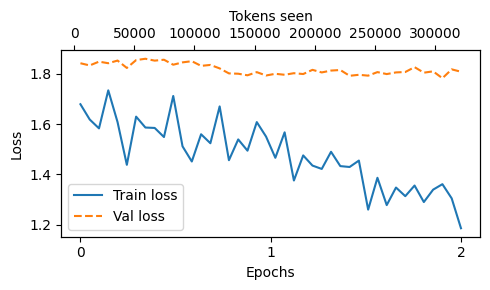

In [203]:
from gpt2_v2 import plot_losses

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [210]:
model.eval()
torch.manual_seed(123)

input_text = format_input(val_data[1])
token_ids = generate_text_simple(
    model=model,
    idx=text_to_tensor(input_text, tokenizer),
    max_new_tokens=35,
    context_size=1024,
    eos_id=50256,
)
generated_text = tensor_to_text(token_ids, tokenizer)
print(generated_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Propose a suitable title for the below article

### Input:
This article discusses the current state of the music industry and how technology has had an impact on its evolution.

### Response:
The current state of the music industry and how technology has had an impact on its evolution.
